# Аналитика в Яндекс.Афише
---
<a id = "Head"></a>

### Описание проекта


Необходимо оптимизировать маркетинговые затраты на основе данных от Яндекс.Афиши с июня 2017 по конец мая 2018 года. Предстоит изучить как люди пользуются продуктом, когда они начинают покупать, сколько денег приносит каждый клиент и когда клиент окупается.

В распоряжении имеются следующие данные: 
    - лог сервера с данными о посещениях сайта Яндекс.Афиши,
    - выгрузка всех заказов за этот период,
    - статистика рекламных расходов.  

### Описание данных

1. Таблица **visits** (лог сервера с информацией о посещениях сайта):

    - Uid — уникальный идентификатор пользователя
    - Device — категория устройства пользователя
    - Start Ts — дата и время начала сессии
    - End Ts — дата и время окончания сессии
    - Source Id — идентификатор рекламного источника, из которого пришел пользователь


2. Таблица **orders** (информация о заказах):

    - Uid — уникальный id пользователя, который сделал заказ
    - Buy Ts — дата и время заказа
    - Revenue — выручка Яндекс.Афиши с этого заказа


3. Таблица **costs** (информация о затратах на маркетинг):

    - source_id — идентификатор рекламного источника
    - dt — дата
    - costs — затраты на этот рекламный источник в этот день

### *План выполнения проекта:*
***

1. [Подготовка предоставленных данных для анализа;](#Step1)
2. [Подготовка отчетов, постороение метрик:](#Step2)

 - [Анализ продукта;](#Step2.1)
 - [Анализ продаж;](#Step2.2)
 - [Маркетинг;](#Step2.3)
 
 
3. [Общий вывод по проекту.](#Step3)

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import math

### Шаг 1. Подготовка предоставленных данных для анализа


<a id = "Step1"></a>

[2](#Step2)   [2.1](#Step2.1)   [2.2](#Step2.2)   [2.3](#Step2.3)   [3](#Step3)   [Начало](#Head)

In [4]:
visits = pd.read_csv(r'C:\Users\vladi\Downloads\data_for_analysis\visits_log.csv')
orders = pd.read_csv(r'C:\Users\vladi\Downloads\data_for_analysis\orders_log.csv')
costs = pd.read_csv(r'C:\Users\vladi\Downloads\data_for_analysis\costs.csv')

In [5]:
visits.head(10)

,Device,End Ts,Source Id,Start Ts,Uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168
5,desktop,2017-09-03 21:36:00,5,2017-09-03 21:35:00,16007536194108375387
6,desktop,2018-01-30 12:09:00,1,2018-01-30 11:13:00,6661610529277171451
7,touch,2017-11-05 15:15:00,3,2017-11-05 15:14:00,11423865690854540312
8,desktop,2017-07-19 10:44:00,3,2017-07-19 10:41:00,2987360259350925644
9,desktop,2017-11-08 13:43:00,5,2017-11-08 13:42:00,1289240080042562063


In [6]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Device     359400 non-null  object
 1   End Ts     359400 non-null  object
 2   Source Id  359400 non-null  int64 
 3   Start Ts   359400 non-null  object
 4   Uid        359400 non-null  uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


In [7]:
visits.duplicated().sum()

0

---
В таблице Visits отсутсвуют пропуски и дубликаты. Необходимо изменить типы данных в столбцах с датой и временем. Также для дальнейшей работы стоит откорректировать названия столбцов: привести все буквы к нижнему регистру и убрать пробелы. 

In [8]:
visits.columns = ['device', 'end_ts', 'source_id', 'start_ts', 'uid']

In [9]:
visits['end_ts'] = pd.to_datetime(visits['end_ts'], format='%Y.%m.%d %H:%M:%S') 

In [10]:
visits['start_ts'] = pd.to_datetime(visits['start_ts'], format='%Y.%m.%d %H:%M:%S') 

In [11]:
print('В таблице представлены', visits['uid'].nunique(), 'уникальных пользователя')


В таблице представлены 228169 уникальных пользователя


In [12]:
visits['device'].value_counts()

desktop    262567
touch       96833
Name: device, dtype: int64

In [13]:
visits['source_id'].value_counts().sort_values(ascending = False)

4     101794
3      85610
5      66905
2      47626
1      34121
9      13277
10     10025
7         36
6          6
Name: source_id, dtype: int64

---
Устройства, с которых пользователи заходили на сайт, разделены на 2 категории: персональные компьютеры и, вероятнее всего, смартфоны / планшеты.

Столбец Source Id делится на 9 рекламных источников, из которых пришли пользователи.

In [14]:
orders.head(10)

,Buy Ts,Revenue,Uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450
5,2017-06-01 08:43:00,0.18,10402394430196413321
6,2017-06-01 08:54:00,1.83,12464626743129688638
7,2017-06-01 09:22:00,1.22,3644482766749211722
8,2017-06-01 09:22:00,3.30,17542070709969841479
9,2017-06-01 09:23:00,0.37,1074355127080856382


In [15]:
orders.info(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Buy Ts   50415 non-null  object 
 1   Revenue  50415 non-null  float64
 2   Uid      50415 non-null  uint64 
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


In [16]:
orders.duplicated().sum()

0

---
В таблице содержатся сведения о 50415 заказах с июня 2017 по май 2018 года включительно. Пропуски и дубликаты отсутствуют. Необходимо подправить названия столбцов и изменить тип данных в столбце "Buy Ts"

In [17]:
orders.columns = ['buy_ts', 'revenue', 'uid']

In [18]:
orders['buy_ts'] = pd.to_datetime(orders['buy_ts'], format='%Y.%m.%d %H:%M:%S') 

In [19]:
print('Всего покупателей:', orders['uid'].nunique())

Всего покупателей: 36523


**Можно посчитать конверсию посетителей сайта в покупателей**

In [20]:
print('Конверсия = {:.0%}'.format(orders['uid'].nunique() / visits['uid'].nunique()))

Конверсия = 16%


In [21]:
costs.head(10)

,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08
5,1,2017-06-06,40.39
6,1,2017-06-07,40.59
7,1,2017-06-08,56.63
8,1,2017-06-09,40.16
9,1,2017-06-10,43.24


In [22]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   source_id  2542 non-null   int64  
 1   dt         2542 non-null   object 
 2   costs      2542 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


In [23]:
orders.duplicated().sum()

0

В таблице с информацией о затратах на маркетинг необходимо исправить тип данных в столбце с датой.

In [24]:
costs['dt'] = pd.to_datetime(costs['dt'], format='%Y.%m.%d') 

In [25]:
costs['source_id'].value_counts().sort_values(ascending = False)

5     364
2     363
4     363
10    363
1     363
3     363
9     363
Name: source_id, dtype: int64

В таблице costs, в отличие от таблицы visits, идентификаторов рекламного источника всего 7. Можно предположить, что источники под № 6 и 7 являются бесплатными. 

### Шаг 2. Подготовка отчетов, постороение метрик

<a id = "Step2"></a>

[1](#Step1)  [2.2](#Step2.2)   [2.3](#Step2.3)   [3](#Step3)   [Начало](#Head)

### 2.1 Анализ продукта

<a id = "Step2.1"></a>

Ответим на следующие вопросы исследования:
    
    - Сколько людей пользуются в день, неделю, месяц?
    - Сколько сессий в день?
    - Сколько длится одна сессия?
    - Как часто люди возвращаются?

Для начала подготовим вспомогательные столбцы для расчета количества пользователей.

In [26]:
visits['session_date'] = visits['start_ts'].dt.date
visits['session_week'] = visits['start_ts'].dt.week
visits['session_month'] = visits['start_ts'].dt.month
visits['session_year'] = visits['start_ts'].dt.year
visits['session_dayofweek'] = visits['start_ts'].dt.dayofweek

In [27]:
visits.sample(5)

,device,end_ts,source_id,start_ts,uid,session_date,session_week,session_month,session_year,session_dayofweek
319815,desktop,2017-09-29 11:50:00,5,2017-09-29 11:46:00,18274511472274981003,2017-09-29,39,9,2017,4
357621,desktop,2017-07-17 12:59:00,3,2017-07-17 12:45:00,11183284446050405224,2017-07-17,29,7,2017,0
109203,desktop,2018-05-22 15:03:00,4,2018-05-22 14:30:00,6708345863732982314,2018-05-22,21,5,2018,1
217206,desktop,2017-12-31 15:00:00,4,2017-12-31 14:54:00,4131879831750607783,2017-12-31,52,12,2017,6
186138,desktop,2018-01-04 19:51:00,4,2018-01-04 19:50:00,7888281304935708898,2018-01-04,1,1,2018,3


Количество уникальных пользователей в день: 907 человек
Максимальное количество уникальных пользователей в день: 3319 человек
Минимальное количество уникальных пользователей в день: 1 человек


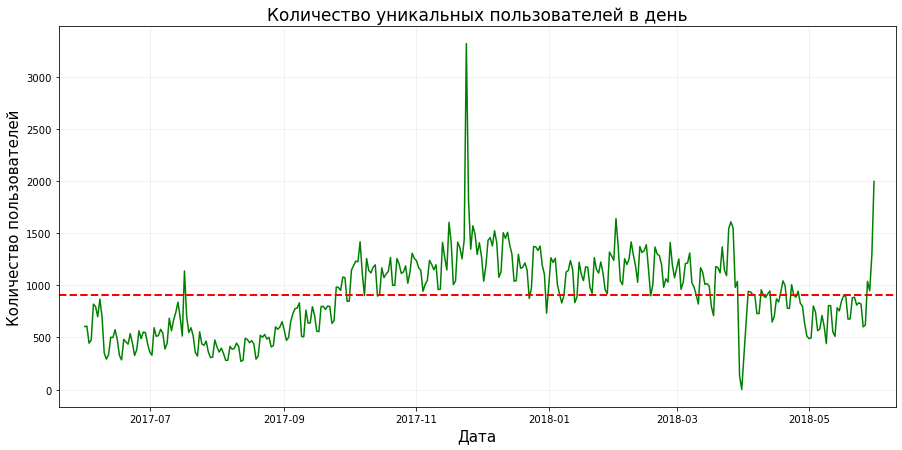

In [28]:
dau = visits.groupby('session_date').agg({'uid' : 'nunique'})
print('Количество уникальных пользователей в день:', int(dau.mean()), 'человек')
print('Максимальное количество уникальных пользователей в день:', int(dau.max()), 'человек')
print('Минимальное количество уникальных пользователей в день:', int(dau.min()), 'человек')

dau.plot(kind = 'line', style = '-', figsize = (15,7), legend = False,
         color = 'green', xlim = ('2017-05-20', '2018-06-10'))
plt.title('Количество уникальных пользователей в день', fontsize = 17)
plt.ylabel("Количество пользователей", fontsize = 15)
plt.xlabel("Дата", fontsize = 15)
plt.grid(axis='both', which='both', alpha=.2)
plt.axhline(y=int(dau.mean()), linewidth=2, ls = '--', color='red');

Количество уникальных пользователей в неделю: 5825 человек


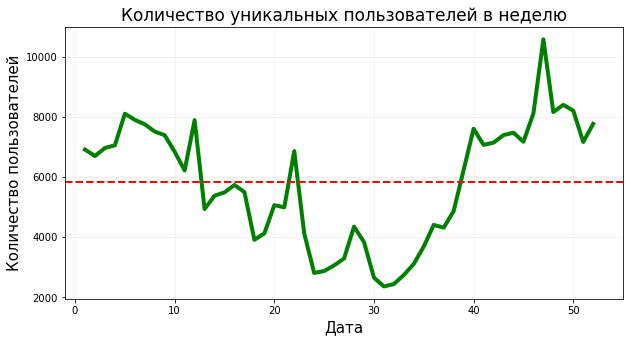

In [29]:
wau = visits.groupby('session_week').agg({'uid' : 'nunique'})
print('Количество уникальных пользователей в неделю:', int(wau.mean()), 'человек')

wau.plot(kind = 'line', style = '-', figsize = (10,5), legend = False,
         color = 'green', xlim = (-1,55), linewidth=4)
plt.title('Количество уникальных пользователей в неделю', fontsize = 17)
plt.ylabel("Количество пользователей", fontsize = 15)
plt.xlabel("Дата", fontsize = 15)
plt.grid(axis='both', which='both', alpha=.2)
plt.axhline(y=int(wau.mean()), linewidth=2, ls = '--', color='red');

Количество уникальных пользователей в месяц: 23228 человек


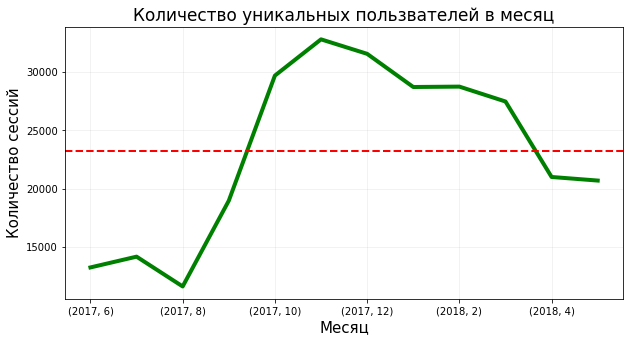

In [30]:
mau = visits.groupby(['session_year', 'session_month']).agg({'uid' : 'nunique'})
print('Количество уникальных пользователей в месяц:', int(mau.mean()), 'человек')

mau.plot(kind = 'line', style = '-', figsize = (10,5), legend = False,
         color = 'green', linewidth=4)
plt.title('Количество уникальных пользвателей в месяц', fontsize = 17)
plt.ylabel("Количество сессий", fontsize = 15)
plt.xlabel("Месяц", fontsize = 15)
plt.grid(axis='both', which='both', alpha=.2)
plt.axhline(y=int(mau.mean()), linewidth=2, ls = '--', color='red');

In [31]:
sessions_per_day = visits.groupby('session_date')['start_ts'].agg('count').mean()
print('Количество сессий в день:', int(sessions_per_day))

Количество сессий в день: 987


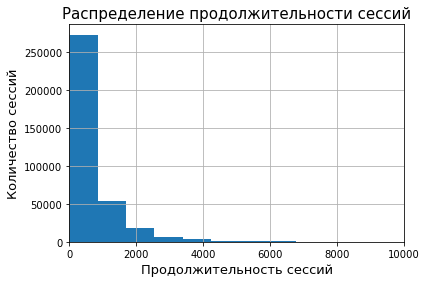

In [32]:
visits['session_duration'] = (visits['end_ts'] - visits['start_ts']).dt.seconds
visits['session_duration'].hist(bins = 100)
plt.xlim(0, 10000)
plt.title('Распределение продолжительности сессий', fontsize = 15)
plt.ylabel("Количество сессий", fontsize = 13)
plt.xlabel("Продолжительность сессий", fontsize = 13);

Распределение времени сессий не является нормальным, поэтому для определения средней продолжительности сессии найдем моду. 

In [33]:
asl = visits['session_duration'].mode()
print('Cредняя продолжительность сессий составляет:', asl[0], 'секунд')

Cредняя продолжительность сессий составляет: 60 секунд


In [34]:
# Рассчитаем регулярность использования сайта:

sticky_mau = dau.mean() / mau.mean()
sticky_wau = dau.mean() / wau.mean()
print('Регулярность использования сайта по отношению к недельной аудитории {:.2%}'.format(sticky_wau[0]))
print('Регулярность использования сайта по отношению к месячной аудитории {:.2%}'.format(sticky_mau[0]))

Регулярность использования сайта по отношению к недельной аудитории 15.59%
Регулярность использования сайта по отношению к месячной аудитории 3.91%


**Рассчитаем коэффициент удержания**

In [35]:
# Подготовим вспомогательный столбец:
first_activity_date = visits.groupby(['uid'])['start_ts'].min()
first_activity_date.name = 'first_activity_date'
visits = visits.join(first_activity_date,on='uid')

In [36]:
# Когорты будем строить в период 1 месяц:
visits['first_activity_month'] = visits['first_activity_date'].astype('datetime64[M]')

In [37]:
# Рассчитаем lifetime в когортах:
visits['session_date'] = pd.to_datetime(visits['session_date'])
visits['cohort_lifetime'] = visits['session_date'] - visits['first_activity_date']
visits['cohort_lifetime'] = visits['cohort_lifetime'] / np.timedelta64(1,'M')
visits['cohort_lifetime'] = visits['cohort_lifetime'].astype('int')
visits['first_activity_month'] = visits['first_activity_month'].dt.strftime('%Y-%m')

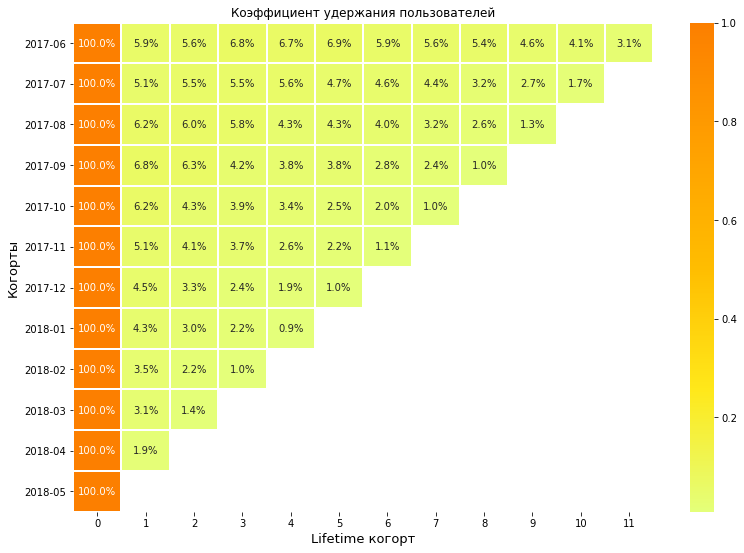

In [38]:
# Сгруппируем данные по когорте и lifetime. Посчитаем для каждой когорты количество 
# активных пользователей на определённый месяц:
cohorts_rr = visits.groupby(['first_activity_month','cohort_lifetime']).agg({'uid':'nunique'}).reset_index()

# Найдём исходное количество пользователей в когорте:
start_visits_count = cohorts_rr[cohorts_rr['cohort_lifetime'] == 0][['first_activity_month','uid']]
start_visits_count = start_visits_count.rename(columns={'uid':'cohort_users'})

# Объединим данные по когортам с исходным количеством пользователей в когорте:
cohorts_rr = cohorts_rr.merge(start_visits_count,on='first_activity_month')

# Pассчитаем Retention Rate:
cohorts_rr['retention'] = cohorts_rr['uid']/cohorts_rr['cohort_users']

retention_pivot = cohorts_rr.pivot_table(index='first_activity_month',
                                      columns='cohort_lifetime',
                                      values='retention',
                                      aggfunc='sum')



plt.figure(figsize=(13, 9))
plt.title('Коэффициент удержания пользователей')
sns.heatmap(retention_pivot, annot=True, fmt='.1%', linewidths=1, linecolor='white', cmap="Wistia")
plt.ylabel("Когорты", fontsize = 13)
plt.xlabel("Lifetime когорт", fontsize = 13);

По всем когортам наблюдается одинаковое поведениие. После первого месяца Retention rate опускается в среднем до 4-6%. Только у когорт июня и июля можно отметить едва заметное повышение показателя на начальных этапах жизни. Во всех остальных случаях коэффициент удержания неуклонно снижается.

**Теперь взглянем на коэффициент оттока пользователей**

In [39]:
cohorts_rr['churn_rate'] = cohorts_rr.groupby('first_activity_month')['uid'].pct_change()

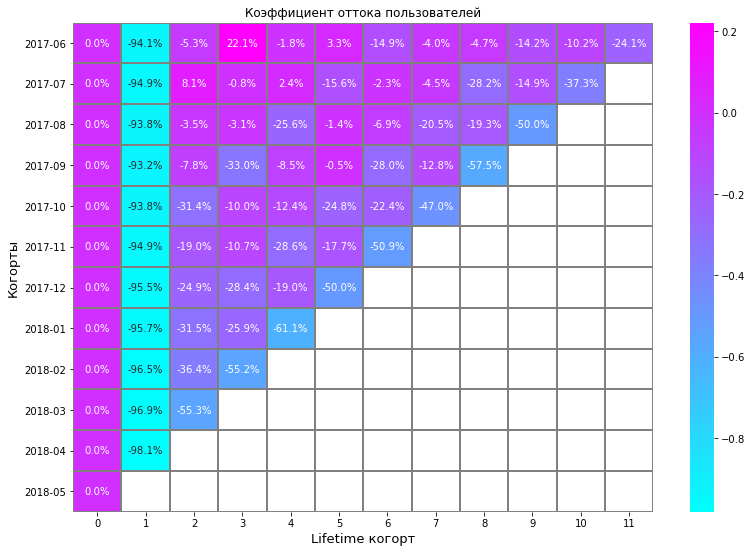

In [40]:
# Построим сводную таблицу и визуализируем результаты:

churn_pivot = cohorts_rr.pivot_table(index='first_activity_month',
                                  columns='cohort_lifetime',
                                  values='churn_rate',
                                  aggfunc='sum')

plt.figure(figsize=(13, 9))
plt.title('Коэффициент оттока пользователей')
sns.heatmap(churn_pivot, annot=True, fmt='.1%', linewidths=1, linecolor='grey', cmap="cool")
plt.ylabel("Когорты", fontsize = 13)
plt.xlabel("Lifetime когорт", fontsize = 13);

Видим, как и на предыдущем графике, что много клиентов перестают пользоваться Яндекс.Афишей после первого месяца. Возможно, подобное поведение является абсолютно нормальным для пользователей подобных сервисов по продаже билетов. Ведь подобных сайтов довольно много, плюс ко всему на большинство событий можно приобрести билеты на официальном сайте организатора того или иного мероприятия.

---
Количество уникальных пользователей:
- в день - 907 человек;
- в неделю - 5825 человек;
- в месяц - 23228 человек.

Cредняя продолжительность сессий составила 60 секунд

Регулярность использования сайта по отношению к недельной аудитории 15.59%

Регулярность использования сайта по отношению к месячной аудитории 3.91%

Когортый анализ показал, что после первого месяца коэффициент удержания пользователей сильно снижается  уже на второй месяц пользования сайтом.  

### 2.2 Анализ продаж

<a id = "Step2.2"></a>

[1](#Step1)  [2](#Step2)   [2.1](#Step2.1)   [2.3](#Step2.3)   [3](#Step3)   [Начало](#Head)

**Ответим на следующие вопросы исследования:**
    
   - Когда люди начинают покупать?
   - [Сколько раз покупают за период?](#q2)
   - [Какой средний чек?](#q3)
   - [Сколько денег приносят? (LTV)](#q4)

**Для ответа на первый вопрос необходимо необходимо провести дополнительные операции с нашими таблицами:**

    1) Сгруппировать таблицу visits по пользователям и найти дату и время их первого посещения сайта;
    2) Сгруппировать таблицу orders по пользователям и найти дату и время первой покупки.

In [41]:
first_visit_date = visits.groupby('uid')['start_ts'].min()
first_visit_date.name = 'first_visit_date'
#first_visit_date

In [42]:
first_order_date = orders.groupby('uid')['buy_ts'].min()
first_order_date.name = 'first_order_date'
#first_order_date

*Объединим полученные данные вместе.*

In [43]:
time_for_order = first_visit_date.to_frame().join(first_order_date, on = 'uid')

In [44]:
# Дельту, время между первым посещением сайта и покупкой, посчитаем в часах:
time_for_order['time_before_purchase'] = round((time_for_order['first_order_date'] - 
                                  time_for_order['first_visit_date']) /  np.timedelta64(1,'h'), 2)

In [45]:
time_for_order['time_before_purchase'].describe()

count    36523.000000
mean       405.669723
std       1129.746220
min          0.000000
25%          0.070000
50%          0.270000
75%         48.285000
max       8719.070000
Name: time_before_purchase, dtype: float64

(0.0, 125.0)

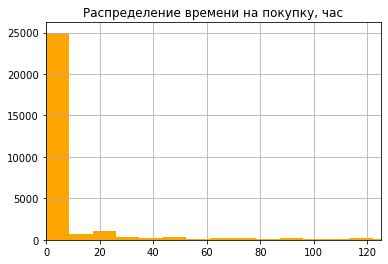

In [46]:
time_for_order['time_before_purchase'].hist(bins  = 1000, color='orange')
plt.title('Распределение времени на покупку, час')
plt.xlim(0, 125)

---
Половина пользователей совершает покупку в течение 16 минут после начала сессии.** 

In [47]:
len(time_for_order[time_for_order['time_before_purchase'] == 0])

2455

Если верить данным, среди пользователей Яндек.Афиши есть 2455 пользователей, которые совершили свою первую покупку сразу как вошли на сайт. Наши данные не учитывают секунды во времени начала сессии и времени покупки. Возможно, что человек при посещении сайта сразу знал, что будет покупать и тратил на все меньше минуты. Тем не менее, стоит обрать внимание разработчиков на это явление.

---
*Рассмотрим сколько покупок пользователи совершили в среднем за год:*                    <a id = "q2"></a>

[2.2](#Step2.2)

In [48]:
sum_of_purchase = orders.groupby('uid')['buy_ts'].count().to_frame()
sum_of_purchase.columns = ['purchases']

In [49]:
sum_of_purchase.describe()

,purchases
count,36523.000000
mean,1.380363
std,3.454461
min,1.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,239.000000


In [50]:
(len(sum_of_purchase[sum_of_purchase['purchases'] > 1 ]) / len(sum_of_purchase))*100

17.227500479150123

---
**Абсолютное большинство совершило лишь одну покупку за рассматриваемый период.** 

Только 17 % пользователей сделали более 1 покупки.

Рассмотрим сколько совершается покупок в динамике по месяцам.

In [51]:
orders = orders.join(first_visit_date, on = 'uid')
orders = orders.join(first_order_date, on = 'uid')

In [52]:
orders['purchase_month'] = orders['buy_ts'].astype('datetime64[M]')

In [53]:
orders = orders.sort_values(by = 'purchase_month')

In [54]:
number_of_purchases = orders.groupby('purchase_month').agg({'uid':'count'})


In [55]:
number_of_purchases

,uid
purchase_month,
2017-06-01,2354
2017-07-01,2363
2017-08-01,1807
2017-09-01,3387
2017-10-01,5679
2017-11-01,5659
2017-12-01,6218
2018-01-01,4721
2018-02-01,5281


Text(0.5, 0, 'Месяц')

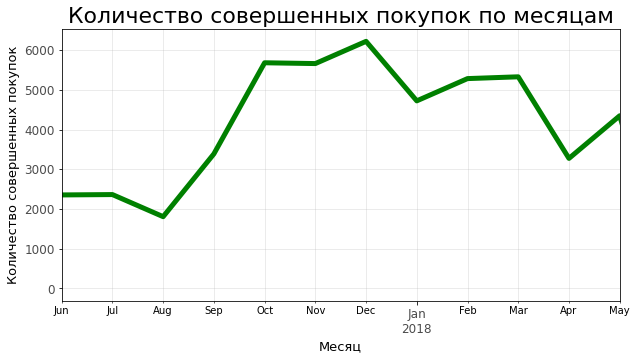

In [56]:
number_of_purchases.plot(kind = 'line', style = '-', figsize = (10,5),lw = 5,
                         color = 'green', legend = False, xlim = ('2017-06-01', '2018-05-01'))
plt.yticks(fontsize=12, alpha=.7)
plt.xticks(fontsize=12, alpha=.7)
plt.title("Количество совершенных покупок по месяцам", fontsize=22)
plt.grid(axis='both', which='both', alpha=.3)
plt.ylabel("Количество совершенных покупок", fontsize = 13)
plt.xlabel("Месяц", fontsize = 13)

---
Наблюдается определенная сезонность. Видим, что пик покупок приходится на декабрь, и это не удивительно. В предновогодний период традиционно проходит много мероприятий, плюс ко всему некоторые люди предпочитают дарить в качестве новогоднего подарка билеты в театр или на концерт. В целом, период с октября по март можно считать наиболее активным. Ближе к лету спрос на билеты снижается. В том числе это связано и с тем, что в теплое время года проходит меньше мероприятий. Например, театры уходят на каникулы, во многих видах спорта наступает межсезонье.

**Посмотрим, как по месяцам изменяется количество пользователей, совершивших покупку впервые.**             


In [57]:
# Выделим из столбца с датой первой покупки месяц:
orders['first_order_month'] = orders['first_order_date'].astype('datetime64[M]')

In [58]:
cohort_grouped = orders.groupby('first_order_month').agg({'uid':'nunique','revenue':'sum'}).reset_index()

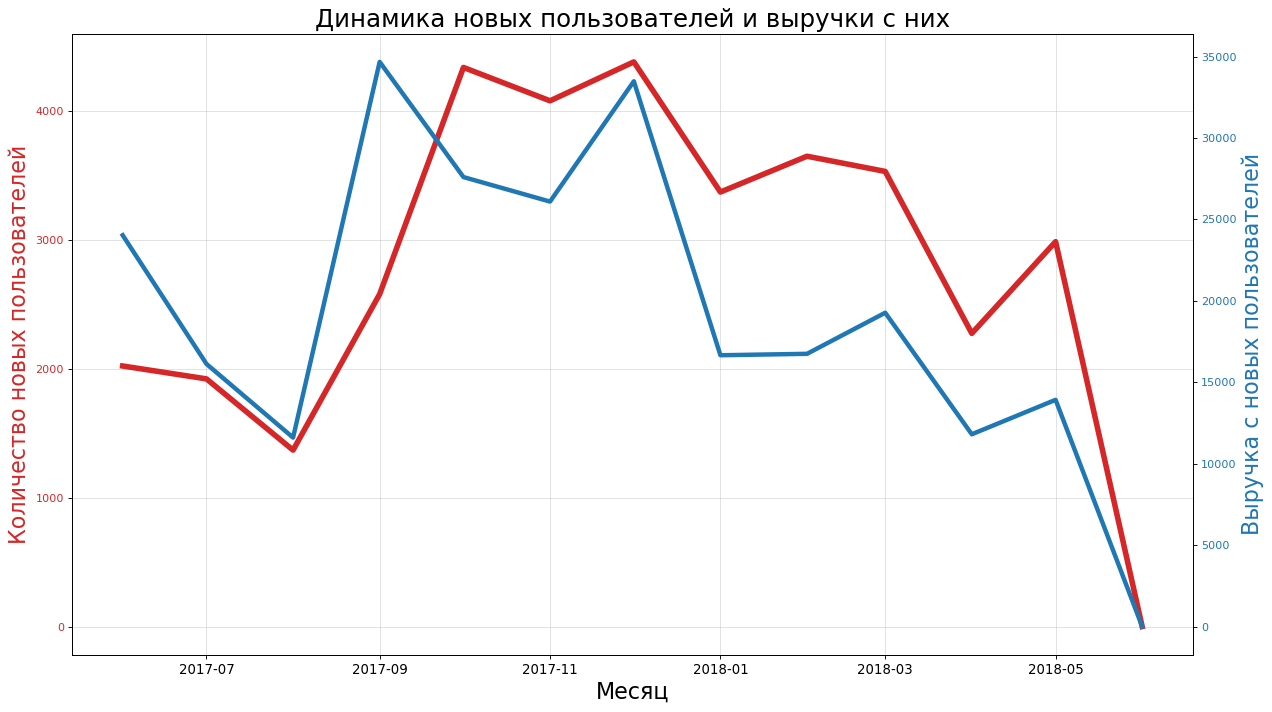

In [59]:
x = cohort_grouped['first_order_month']
y1 = cohort_grouped['uid']
y2 = cohort_grouped['revenue']

# Построение первого графика 
fig, ax1 = plt.subplots(1,1,figsize=(16,9), dpi= 80)
ax1.plot(x, y1, color='tab:red', linewidth=5)

# Постороение второго графика
ax2 = ax1.twinx()
ax2.plot(x, y2, color='tab:blue', linewidth=4)


# ax1 (Левая ось ординат)
ax1.set_xlabel('Месяц', fontsize=20)
ax1.tick_params(axis='x', rotation=0, labelsize=12)
ax1.set_ylabel('Количество новых пользователей', color='tab:red', fontsize=20)
ax1.tick_params(axis='y', rotation=0, labelcolor='tab:red' )
ax1.grid(alpha=.4)

# ax2 (Правая ось ординат)
ax2.set_ylabel("Выручка с новых пользователей", color='tab:blue', fontsize=20)
ax2.tick_params(axis='y', labelcolor='tab:blue')
ax2.set_title("Динамика новых пользователей и выручки с них", fontsize=22)
fig.tight_layout()
plt.show()

---
На графике видно, что динамика появления новых покупателей и выручки по ним практически совпадает. Только в октябре наблюдается расхождение, когда число клиентов увеличилось, а выручка снизилилась. Возможно в этом месяце цены на билеты дешевле, чем обычно.  

In [60]:
orders.sample(5)

,buy_ts,revenue,uid,first_visit_date,first_order_date,purchase_month,first_order_month
2340,2017-06-30 21:39:00,2.20,15970927890660121981,2017-06-30 21:18:00,2017-06-30 21:39:00,2017-06-01,2017-06-01
26847,2017-12-29 02:26:00,1.71,9541068605308530088,2017-12-29 02:26:00,2017-12-29 02:26:00,2017-12-01,2017-12-01
1979,2017-06-25 21:33:00,6.72,2374313720248290308,2017-06-25 21:33:00,2017-06-25 21:33:00,2017-06-01,2017-06-01
23323,2017-12-11 12:18:00,7.33,9952410608049761025,2017-06-05 13:47:00,2017-06-10 18:01:00,2017-12-01,2017-06-01
16982,2017-11-10 23:44:00,12.53,12149009409541318226,2017-11-10 10:17:00,2017-11-10 23:44:00,2017-11-01,2017-11-01


In [61]:
orders[orders['first_order_month'] != '2018-06-01'].pivot_table(index = 'first_order_month',
    columns='purchase_month',
    values='uid',
    aggfunc='nunique')

purchase_month,2017-06-01,2017-07-01,2017-08-01,2017-09-01,2017-10-01,2017-11-01,2017-12-01,2018-01-01,2018-02-01,2018-03-01,2018-04-01,2018-05-01
first_order_month,,,,,,,,,,,,
2017-06-01,2023.0,61.0,50.0,54.0,88.0,67.0,62.0,47.0,58.0,45.0,45.0,53.0
2017-07-01,NaN,1923.0,52.0,57.0,64.0,49.0,38.0,36.0,39.0,42.0,22.0,26.0
2017-08-01,NaN,NaN,1370.0,58.0,53.0,44.0,40.0,32.0,30.0,44.0,19.0,31.0
2017-09-01,NaN,NaN,NaN,2581.0,130.0,100.0,74.0,52.0,64.0,66.0,37.0,43.0
2017-10-01,NaN,NaN,NaN,NaN,4340.0,206.0,123.0,92.0,93.0,72.0,56.0,67.0
2017-11-01,NaN,NaN,NaN,NaN,NaN,4081.0,222.0,120.0,106.0,81.0,48.0,62.0
2017-12-01,NaN,NaN,NaN,NaN,NaN,NaN,4383.0,146.0,103.0,97.0,50.0,63.0
2018-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3373.0,114.0,83.0,43.0,45.0
2018-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3651.0,118.0,58.0,39.0


---
После первого месяца количество покупателей в когорте сильно снижается. В каждом новом месяце основную выручку делают новые клиенты. 

**Рассмотрим теперь выручку с заказов, рассчитаем средний чек.**   <a id = "q3"></a>
   
   [2.2](#Step2.2)

---

In [62]:
orders['revenue'].describe()

count    50415.000000
mean         4.999647
std         21.818359
min          0.000000
25%          1.220000
50%          2.500000
75%          4.890000
max       2633.280000
Name: revenue, dtype: float64

Медианное значение выркучки с одного заказа за весь рассматриваемый период составляет 2.5 у.е.

In [63]:
month_revenue = orders.groupby('purchase_month')['revenue'].agg({'sum', 'count'}).reset_index()

In [64]:
month_revenue['revenue_per_user'] = month_revenue['sum'] / month_revenue['count']

**Сравним на графике динамику изменения ежемесячного количества покупок и размера средненего чека.**

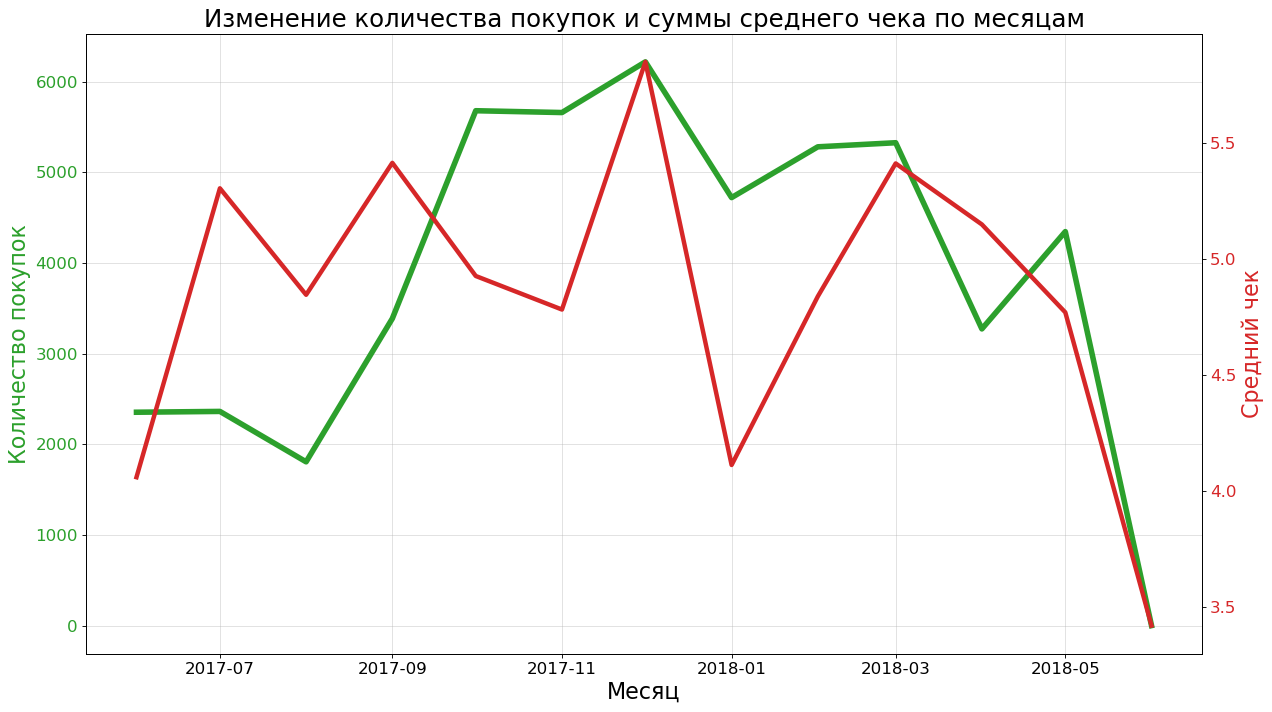

In [65]:
x = number_of_purchases.index
y1 = number_of_purchases['uid']
y2 = month_revenue['revenue_per_user']

# Построение первого графика 
fig, ax1 = plt.subplots(1,1,figsize=(16,9), dpi= 80)
ax1.plot(x, y1, color='tab:green', linewidth=5)

# Постороение второго графика
ax2 = ax1.twinx()
ax2.plot(x, y2, color='tab:red', linewidth=4)

# ax1 (Левая ось ординат)
ax1.set_xlabel('Месяц', fontsize=20)
ax1.tick_params(axis='x', rotation=0, labelsize=15)
ax1.set_ylabel('Количество покупок', color='tab:green', fontsize=20)
ax1.tick_params(axis='y', rotation=0, labelcolor='tab:green', labelsize=15 )
ax1.grid(alpha=.4)

# ax2 (Правая ось ординат)
ax2.set_ylabel("Средний чек", color='tab:red', fontsize=20)
ax2.tick_params(axis='y', labelcolor='tab:red', labelsize = 15)
ax2.set_title("Изменение количества покупок и суммы среднего чека по месяцам", fontsize=22)
fig.tight_layout()
plt.show()

На данном графике мы видим подтверждение нашего предположения, что цены на билеты в октябре 2017 года снижались. Рост числа покупателей не смог компенсировать падение выручки, которое можно наблюдать на предыдущем графике. Самое сильное падение размера среднего чека произошло в январе 2018 г. Затем к марту цены вновь выросли и размер покупок на одного клиента вернулся к показателям сентября 2017 года.

---
**Оценим, как изменяется средний чек в зависимости от времени, прошедшего с момента первой покупки:**


In [66]:
# Cгруппируем данные по когорте first_order_month и месяцу совершения заказа purchase_month:
orders_grouped_by_cohorts = orders.groupby(['first_order_month', 'purchase_month']).\
agg({'uid':'nunique','revenue':'sum'}).reset_index()

# Надем средни чек для когорт:
orders_grouped_by_cohorts['revenue_per_user'] = orders_grouped_by_cohorts['revenue'] / orders_grouped_by_cohorts['uid']

# Дополнительно избавимся от покупки в июне 2018 года:
orders_grouped_by_cohorts = orders_grouped_by_cohorts[orders_grouped_by_cohorts['first_order_month'] != '2018-06-01']

In [67]:
# Найдём lifetime когорты. Из месяца совершения заказа вычтем месяц когорты:
orders_grouped_by_cohorts['cohort_lifetime'] = orders_grouped_by_cohorts['purchase_month'] - \
orders_grouped_by_cohorts['first_order_month']

In [68]:
orders_grouped_by_cohorts['cohort_lifetime'] = \
(orders_grouped_by_cohorts['cohort_lifetime'] / np.timedelta64(1,'M')).round().astype(int)

In [69]:
orders_grouped_by_cohorts['first_order_month'] = orders_grouped_by_cohorts['first_order_month'].\
dt.strftime('%Y-%m')

In [70]:
revenue_per_user_cohorts = orders_grouped_by_cohorts.pivot_table(index='first_order_month',
                                                                 columns='cohort_lifetime',
                                                                 values='revenue_per_user',
                                                                 aggfunc='mean')

Text(0.5, 60.0, 'Lifetime когорт')

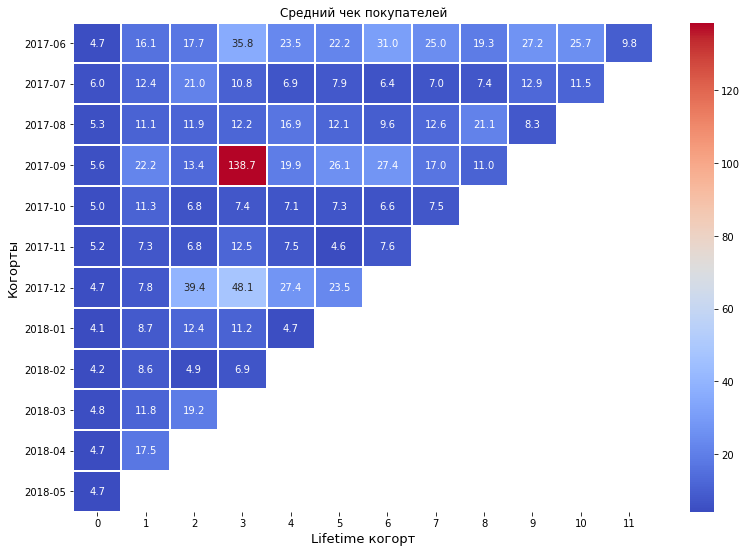

In [71]:
# Построим тепловую карту:
plt.figure(figsize=(13, 9))
plt.title('Средний чек покупателей')
sns.heatmap(revenue_per_user_cohorts, annot=True, fmt='.1f', linewidths=1, linecolor='white', cmap="coolwarm")
plt.ylabel("Когорты", fontsize = 13)
plt.xlabel("Lifetime когорт", fontsize = 13)

Видим, что на второй месяц средний чек когорт возрастает. Аномально высокий рост демонстрирует когорта сентября 2017 года на 3-й месяц. Возможно это связано с очень большим заказом какого-то покупателя. Хорошие показатели у когорты декабря 2017 года со 2-го месяца. Как мы выяснили ранее, количество покупателей каждой когорты со второго месяца сильно сокращается. Это значит, оставшиеся покупатели заказывывают на большую сумму. 

---

**Рассчитаем итоговую ценность клиента или LTV**
<a id = "q4"></a>

[2.2](#Step2.2)

Для начала посчитаем количество новых покупателей за каждый месяц:

In [72]:
cohort_sizes = orders.groupby('first_order_month').agg({'uid': 'nunique'}).reset_index()
cohort_sizes.columns = ['first_order_month', 'n_buyers']

In [73]:
# Сгруппируем таблицу заказов по месяцу первой покупки и месяцу каждого заказа и сложим выручку
cohorts = orders.groupby(['first_order_month','purchase_month']).agg({'revenue': 'sum'}).reset_index()

In [74]:
# Добавим в таблицу cohorts данные о том, сколько людей первый раз совершили покупку в каждый месяц:
report = pd.merge(cohort_sizes, cohorts, on='first_order_month')
#report.head()

In [75]:
report['age'] = ((report['purchase_month'] - report['first_order_month']) / np.timedelta64(1, 'M')).round().astype('int')
report.head()

,first_order_month,n_buyers,purchase_month,revenue,age
0,2017-06-01,2023,2017-06-01,9557.49,0
1,2017-06-01,2023,2017-07-01,981.82,1
2,2017-06-01,2023,2017-08-01,885.34,2
3,2017-06-01,2023,2017-09-01,1931.30,3
4,2017-06-01,2023,2017-10-01,2068.58,4


In [76]:
# Разделим валовую прибыль когорт за каждый месяц на общее число пользователей в каждой когорте.
report['ltv'] = report['revenue'] / report['n_buyers']

In [77]:
ltv = report[report['first_order_month'] != '2018-06-01'].pivot_table(
        index='first_order_month', 
        columns='age', 
        values='ltv', 
        aggfunc={'mean'}).sum(axis=1).round(2)
ltv

first_order_month
2017-06-01    11.88
2017-07-01     8.39
2017-08-01     8.47
2017-09-01    13.44
2017-10-01     6.36
2017-11-01     6.40
2017-12-01     7.64
2018-01-01     4.94
2018-02-01     4.59
2018-03-01     5.46
2018-04-01     5.19
2018-05-01     4.66
dtype: float64

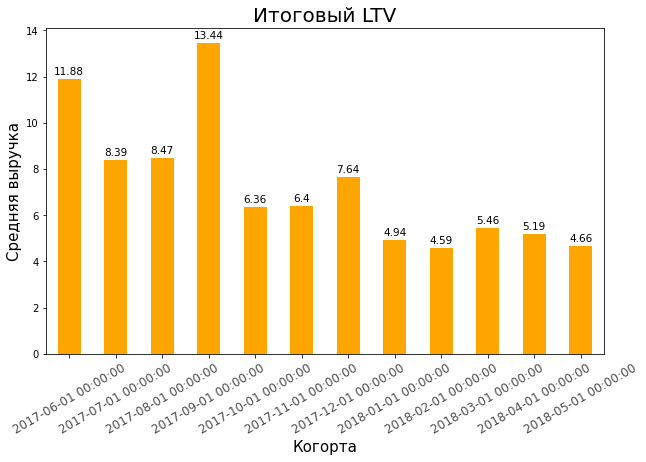

In [78]:
ltv.plot(kind = 'bar', figsize = (10, 6), color = 'orange', width=.5)
plt.ylabel("Средняя выручка", fontsize = 15)
plt.xlabel("Когорта", fontsize = 15)
plt.title('Итоговый LTV', fontsize=20)
plt.xticks(fontsize=12, alpha=.7, rotation = 30)
for i, count in enumerate(ltv):
    plt.text(i, count+0.2, count, horizontalalignment='center', fontsize = 10.5)

Больше всего в среднем принесли пользователи из когорты сентября 2017 года - по 13.44 у.е. Такое значение получилось за счет крупных покупок, сделанных этой когортой в декабре.

В среднем каждый покупатель из первой когорты принес по 11.88 у.е. выручки за 12 месяцев «жизни».

Так как рассматриваемые когорты прожили разный период времени сравнивать конечную ценность покупателей не совсем корректно. Сравним ltv когорт за первые 6 месяцев "жизни". Когорты, которые просуществовали меньше этого срока, отсеим. 

In [79]:
report_filtered = report[(report['first_order_month'] >= '2017-06-01') & 
       (report['first_order_month'] <= '2017-12-01')&
       (report['age'] < 6)]

In [80]:
ltv_filtered = report_filtered.pivot_table(
        index='first_order_month', 
        columns='age', 
        values='ltv', 
        aggfunc={'mean'}).sum(axis=1).round(2)

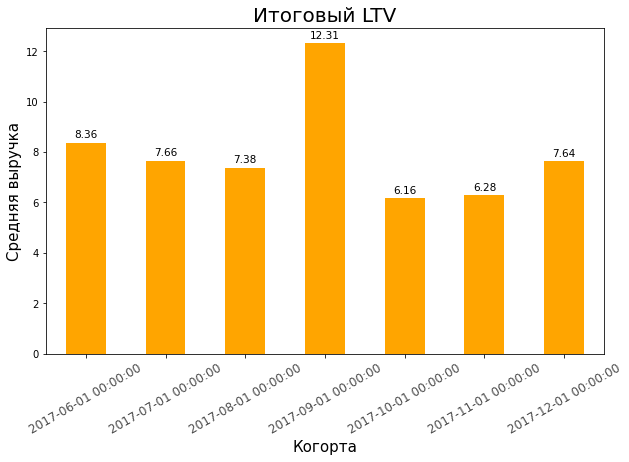

In [81]:
ltv_filtered.plot(kind = 'bar', figsize = (10, 6), color = 'orange', width=.5)
plt.ylabel("Средняя выручка", fontsize = 15)
plt.xlabel("Когорта", fontsize = 15)
plt.title('Итоговый LTV', fontsize=20)
plt.xticks(fontsize=12, alpha=.7, rotation = 30)
for i, count in enumerate(ltv_filtered):
    plt.text(i, count+0.2, count, horizontalalignment='center', fontsize = 10.5)

За 6 месяцев лучше всего себя показала когорта сентября 2017 года. Меньше всех в среднем принесли покупатели когорты октября 2017 года - 6.16 у.е.

### 2.3 Маркетинг

<a id = "Step2.3"></a>

[1](#Step1)  [2](#Step2)   [2.1](#Step2.1)   [2.2](#Step2.2)   [3](#Step3)   [Начало](#Head)

В данном разделе проекта попытаемся ответить на вопросы:    
   - Сколько денег потратили? Всего / на каждый источник / по времени
   - [Сколько стоило привлечение одного покупателя из каждого источника?](#q5)
   - [На сколько окупились расходы? (ROI)](#q6)

In [82]:
print('За весь рассматриваемый период было потрачено', costs['costs'].sum(), 'у.е.')

За весь рассматриваемый период было потрачено 329131.62 у.е.


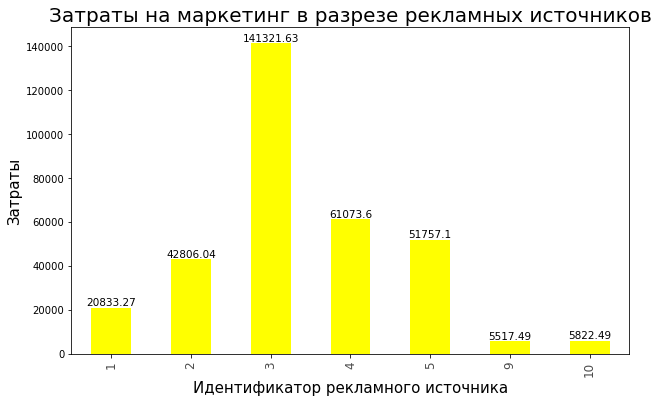

In [83]:
plot1 = costs.groupby('source_id')['costs'].sum().round(2)
plot1.plot(kind = 'bar', figsize = (10, 6), color = 'yellow', width=.5)
plt.ylabel("Затраты", fontsize = 15)
plt.xlabel("Идентификатор рекламного источника", fontsize = 15)
plt.title('Затраты на маркетинг в разрезе рекламных источников', fontsize=20)
plt.xticks(fontsize=12, alpha=.7)
for i, count in enumerate(plot1):
    plt.text(i, count+1000, count, horizontalalignment='center', fontsize = 10.5)

---
Всего на маркетинг было затрачено 329131.62 у.е. Около половины всего рекламного бюджета ушло на источник №3. 

In [84]:
costs['month'] = costs['dt'].astype('datetime64[M]')

In [85]:
monthly_costs = costs.groupby('month')['costs'].sum()
monthly_costs

month
2017-06-01    18015.00
2017-07-01    18240.59
2017-08-01    14790.54
2017-09-01    24368.91
2017-10-01    36322.88
2017-11-01    37907.88
2017-12-01    38315.35
2018-01-01    33518.52
2018-02-01    32723.03
2018-03-01    30415.27
2018-04-01    22289.38
2018-05-01    22224.27
Name: costs, dtype: float64

Text(0.5, 0, 'Месяц')

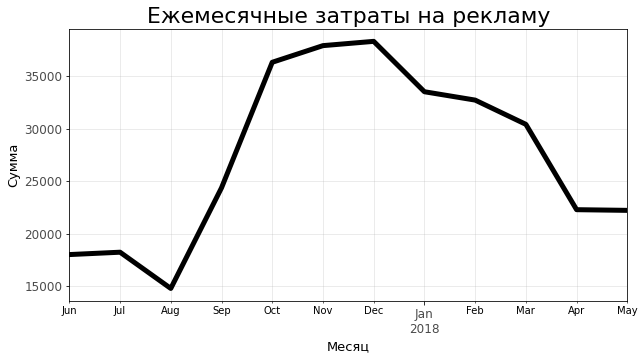

In [86]:
monthly_costs.plot(kind = 'line', style = '-', figsize = (10,5),lw = 5, color = 'black', legend = False)
plt.yticks(fontsize=12, alpha=.7)
plt.xticks(fontsize=12, alpha=.7)
plt.title("Ежемесячные затраты на рекламу", fontsize=22)
plt.grid(axis='both', which='both', alpha=.3)
plt.ylabel("Сумма", fontsize = 13)
plt.xlabel("Месяц", fontsize = 13)

Подобно графику ежемесячного числа покупок, здесь тоже наблюдается сезонность. С сентября по декабрь затраты на рекламу постоянно растут. Пик затрат приходится на декабрь, что говорит об активном привлечении покупатей в предпраздничный период. Далее к лету рекламный бюджет сокращается.

Посчитаем стоимость привлечения клиента для каждой когорты. Cуммарные расходы за каждый месяц мы уже нашли. Добавим данные о расходах в отчёт и затем поделим их на количество покупателей в каждой когорте:

In [87]:
report_2 = pd.merge(report, monthly_costs, left_on='first_order_month', right_on='month')

In [88]:
report_2['cac'] = report_2['costs'] / report_2['n_buyers']
report_2.head()

,first_order_month,n_buyers,purchase_month,revenue,age,ltv,costs,cac
0,2017-06-01,2023,2017-06-01,9557.49,0,4.724414,18015.0,8.905091
1,2017-06-01,2023,2017-07-01,981.82,1,0.485329,18015.0,8.905091
2,2017-06-01,2023,2017-08-01,885.34,2,0.437637,18015.0,8.905091
3,2017-06-01,2023,2017-09-01,1931.30,3,0.954671,18015.0,8.905091
4,2017-06-01,2023,2017-10-01,2068.58,4,1.022531,18015.0,8.905091


In [89]:
cac = report_2[report_2['first_order_month'] != '2018-06-01'].pivot_table(
        index='first_order_month', 
        columns='age', 
        values='cac', 
        aggfunc={'mean'}).sum(axis=1).round(2)
cac

first_order_month
2017-06-01    106.86
2017-07-01    104.34
2017-08-01    107.96
2017-09-01     84.97
2017-10-01     66.95
2017-11-01     65.02
2017-12-01     52.45
2018-01-01     49.69
2018-02-01     35.85
2018-03-01     25.83
2018-04-01     19.59
2018-05-01      7.44
dtype: float64

Больше всего было потрачено на когорту августа 2017 года.

**Сколько стоило привлечение одного покупателя из каждого источника?**
<a id = "q5"></a>

[2.3](#Step2.3)

In [90]:
#Создадим таблицу пользователей, которые совершали покупки, с информацией о том, 
#с какого источника они были привлечены впервые и каким устройством пользовались. 
paying_users = (visits[visits['uid'].isin(orders['uid'].unique())]
               .sort_values(by = ['uid', 'start_ts']).groupby('uid')
               .agg({'start_ts':'first', 'source_id':'first', 'device':'first'})
               .rename(columns = {'start_ts':'acquisition_ts'}))
paying_users['acquisition_date'] = paying_users['acquisition_ts'].dt.date
paying_users['acquisition_month'] = paying_users['acquisition_ts'].astype('datetime64[M]')

costs = costs.rename(columns = {'dt':'acquisition_date'})
paying_users = (paying_users.reset_index().set_index(['source_id', 'acquisition_date'])
               .join(costs.set_index(['source_id', 'acquisition_date']), how = 'left'))
# Добавим стоимость привлеченияя индивидуального пользователя:
user_cost = (paying_users.groupby(['source_id','acquisition_date']).agg({'device':'count', 'costs':'max'})
            .rename(columns = {'device':'users'}))
user_cost['payer_aquisition_cost'] = user_cost['costs'] / user_cost['users']
paying_users = paying_users.join(user_cost['payer_aquisition_cost'], how = 'left')
paying_users = paying_users.reset_index().set_index('uid')[['acquisition_ts', 'acquisition_date','acquisition_month',
                                                           'source_id', 'device', 'payer_aquisition_cost']]
paying_users = (paying_users.join(orders.groupby('uid')
                                  .agg({'revenue': 'sum'})
                                 .rename(columns = {'revenue':'total_revenue'}), how = 'left'))

#paying_users.sample(10)

In [91]:
cost_vs_revenue = paying_users.pivot_table(index = 'source_id', 
                                           values = ['payer_aquisition_cost', 'total_revenue'],
                                          aggfunc = {'payer_aquisition_cost': ['count','mean'], 'total_revenue': 'mean'})

In [92]:
cost_vs_revenue.columns = ['number_of_buyers', 'mean_costs', 'mean_revenue']

In [93]:
cost_vs_revenue

,number_of_buyers,mean_costs,mean_revenue
source_id,,,
1,2899,7.171449,10.724577
2,3506,12.176372,13.383802
3,10473,13.493901,5.204931
4,10296,5.930255,5.506685
5,6931,7.467378,7.592558
7,0,NaN,1.220000
9,1088,3.858318,5.293566
10,1329,4.064169,3.348631


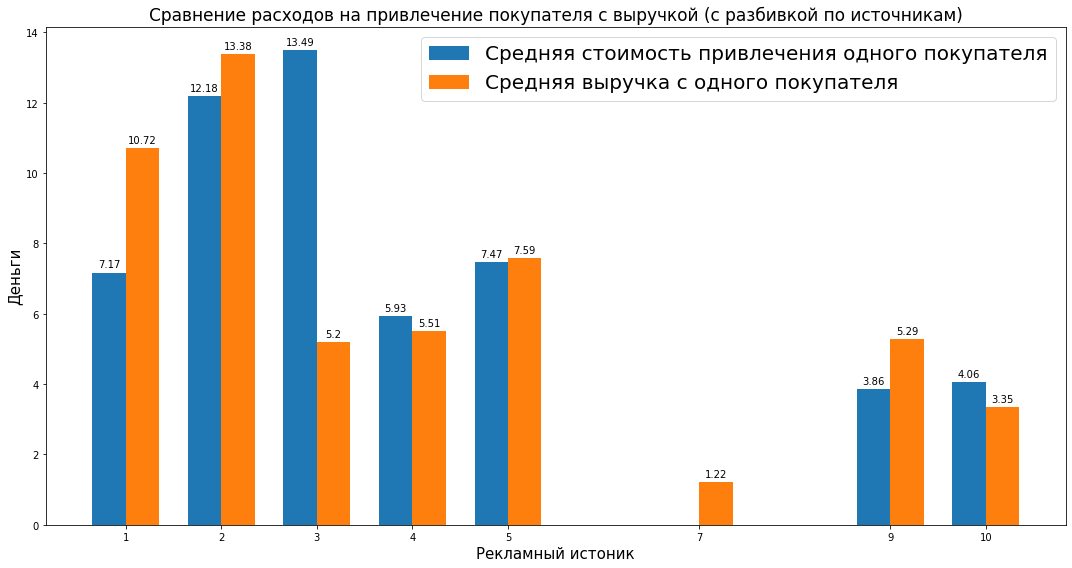

In [94]:
x = cost_vs_revenue.index  
width = 0.35

fig, ax = plt.subplots(figsize = (15,8))
rects1 = ax.bar(x - width/2, cost_vs_revenue['mean_costs'].round(2), 
                width, label='Средняя стоимость привлечения одного покупателя')
rects2 = ax.bar(x + width/2, cost_vs_revenue['mean_revenue'].round(2), 
                width, label='Средняя выручка с одного покупателя')


ax.set_ylabel('Деньги', fontsize=15)
ax.set_xlabel('Рекламный истоник', fontsize=15)
ax.set_title('Сравнение расходов на привлечение покупателя с выручкой (с разбивкой по источникам)', fontsize=17)
ax.set_xticks(x)
ax.legend(prop={'size': 20})


def autolabel(rects):
    
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()

Среди рассматриваемых источников привлечения покупателей 3-й, 4-й и 10-й являются убыточными. Средняя стоимость привлечения одного покупателя через источник №3 в 2.5 раза превышает получаемую выручку. Самым успешным каналом привлечения можно считать № 1 - средняя выручка с одного покупателя превышает средние расходы на 3.55 у.е.

**На сколько окупились расходы?**   <a id = "q6"></a>

[2.3](#Step2.3) 

Для расчетов используем таблицу, которую получили ранее. Рассчитаем ROMI.

In [95]:
report_2['romi'] = report_2['ltv'] / report_2['cac']

Посчитаем накопительный ROMI:

In [96]:
report_2['first_order_month_new'] = report_2['first_order_month'].dt.strftime('%Y.%m')

In [97]:
output = report_2.pivot_table(
        index='first_order_month_new', 
        columns='age', 
        values='romi', 
        aggfunc='mean').cumsum(axis=1).round(2)

Text(0.5, 60.0, 'Lifetime когорт')

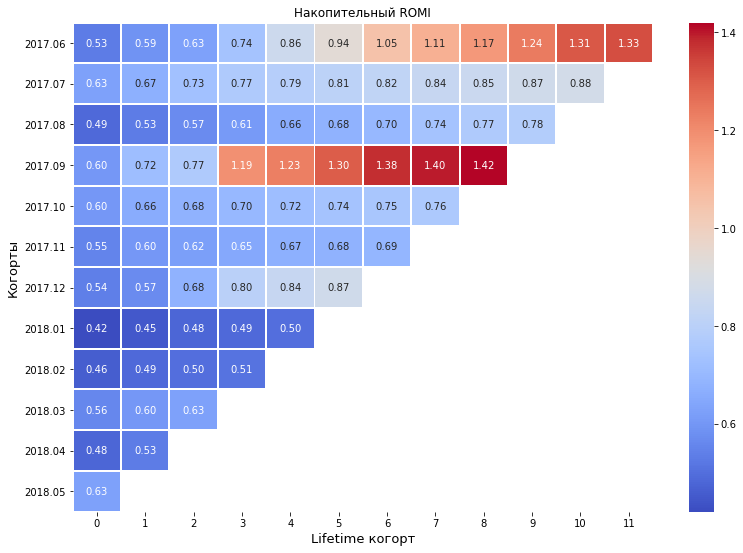

In [98]:
plt.figure(figsize=(13, 9))
plt.title('Накопительный ROMI')
sns.heatmap(output, annot=True, fmt='.2f', linewidths=1, linecolor='white', cmap="coolwarm")
plt.ylabel("Когорты", fontsize = 13)
plt.xlabel("Lifetime когорт", fontsize = 13)

In [99]:
output.mean(axis=0)

age
0     0.540833
1     0.582727
2     0.629000
3     0.717778
4     0.783750
5     0.860000
6     0.898333
7     0.970000
8     1.052500
9     0.963333
10    1.095000
11    1.330000
dtype: float64

---
Июньская когорта окупилась к 7 месяцу. Когорта сентбря окупилась на 4 месяц. Когорта июля и декабря близки к окупаемости, правда рост ROMI сильно замедлился. 
В среднем когорты окупаются после 9 месяцев.

---
Для рассчета метрик по устройствам и по рекламным источникам понадобится подготовить дополнительную таблицу. Добавим к таблице заказов данные о том, из какого источника пришел покупатель, а также каким устройством он пользовался. 

In [100]:
orders = pd.merge(orders, paying_users[['source_id', 'device']], left_on = 'uid', right_index=True , how = 'left')

--------------- Расчет окупаемости для рекламного источника № 1 ---------------
None
____Средняя ценность покупателя____
age
0      6.313333
1      7.460909
2      8.872000
3      9.632222
4     10.887500
5     12.011429
6     13.763333
7     15.774000
8     19.100000
9     23.136667
10    26.430000
11    33.640000
dtype: float64


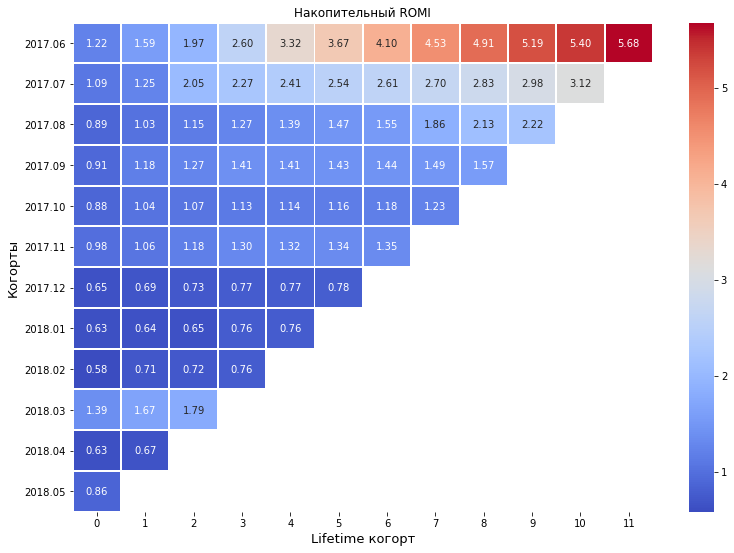

age
0     0.892500
1     1.048182
2     1.258000
3     1.363333
4     1.565000
5     1.770000
6     2.038333
7     2.362000
8     2.860000
9     3.463333
10    4.260000
11    5.680000
dtype: float64

--------------- Расчет окупаемости для рекламного источника № 2 ---------------
None
____Средняя ценность покупателя____
age
0      6.501667
1      8.124545
2      9.973000
3     12.088889
4     13.802500
5     15.492857
6     12.831667
7     14.058000
8     14.952500
9     11.383333
10    13.780000
11    16.660000
dtype: float64


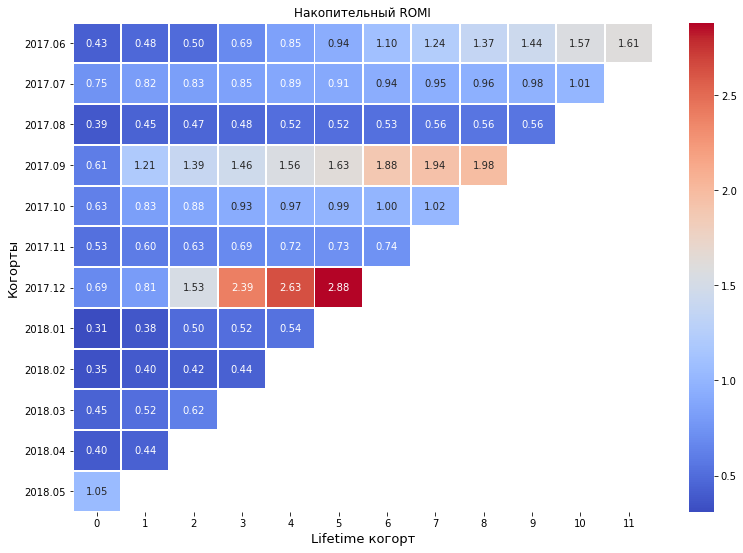

age
0     0.549167
1     0.630909
2     0.777000
3     0.938889
4     1.085000
5     1.228571
6     1.031667
7     1.142000
8     1.217500
9     0.993333
10    1.290000
11    1.610000
dtype: float64

--------------- Расчет окупаемости для рекламного источника № 3 ---------------
None
____Средняя ценность покупателя____
age
0     4.605833
1     4.994545
2     5.082000
3     5.265556
4     5.506250
5     5.731429
6     5.961667
7     6.240000
8     6.452500
9     6.360000
10    6.510000
11    5.710000
dtype: float64


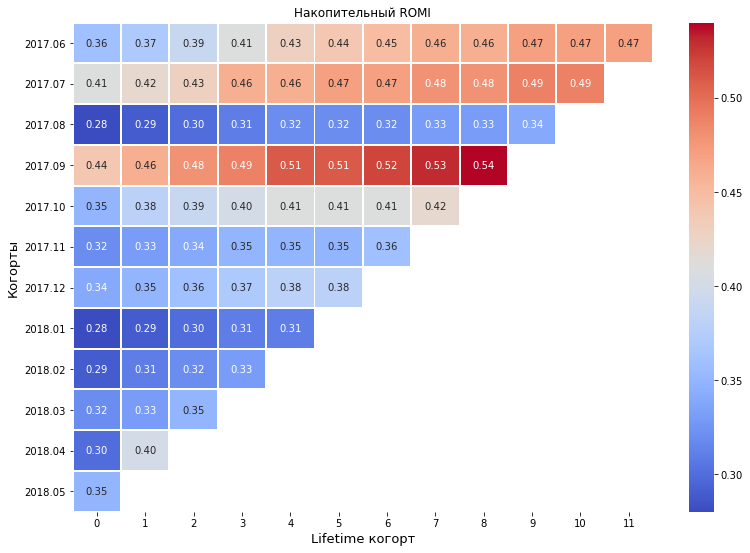

age
0     0.336667
1     0.357273
2     0.366000
3     0.381111
4     0.396250
5     0.411429
6     0.421667
7     0.444000
8     0.452500
9     0.433333
10    0.480000
11    0.470000
dtype: float64

--------------- Расчет окупаемости для рекламного источника № 4 ---------------
None
____Средняя ценность покупателя____
age
0      4.666667
1      4.855455
2      4.945000
3      5.175556
4      5.512500
5      6.032857
6      6.806667
7      6.978000
8      7.547500
9      7.823333
10     9.140000
11    12.090000
dtype: float64


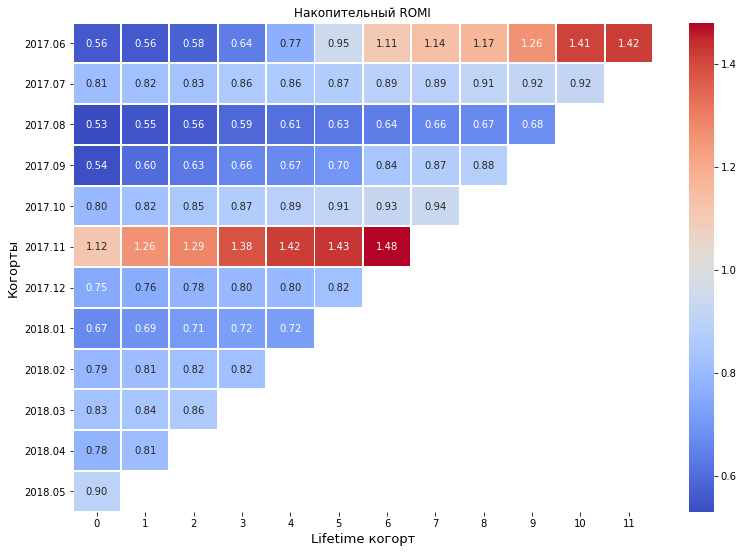

age
0     0.756667
1     0.774545
2     0.791000
3     0.815556
4     0.842500
5     0.901429
6     0.981667
7     0.900000
8     0.907500
9     0.953333
10    1.165000
11    1.420000
dtype: float64

--------------- Расчет окупаемости для рекламного источника № 5 ---------------
None
____Средняя ценность покупателя____
age
0      4.835000
1      5.202727
2      5.584000
3      7.681111
4      8.445000
5      9.345714
6     10.326667
7     11.604000
8     13.222500
9      9.320000
10     9.030000
11    11.400000
dtype: float64


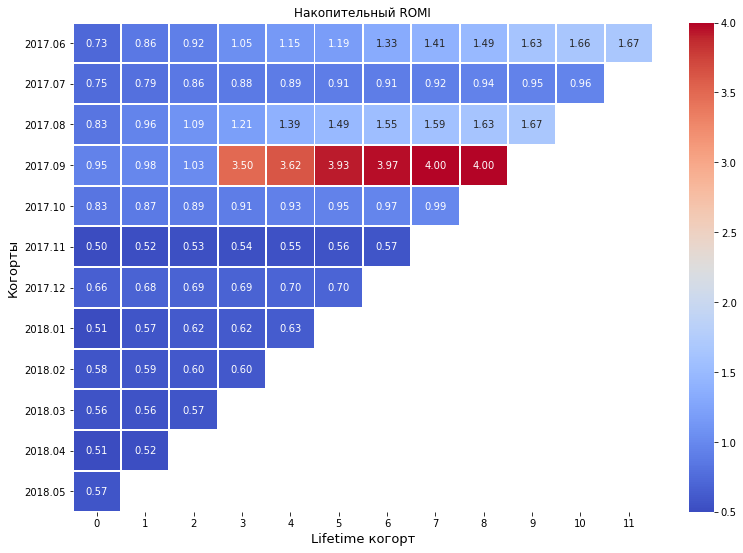

age
0     0.665000
1     0.718182
2     0.780000
3     1.111111
4     1.232500
5     1.390000
6     1.550000
7     1.782000
8     2.015000
9     1.416667
10    1.310000
11    1.670000
dtype: float64

--------------- Расчет окупаемости для рекламного источника № 9 ---------------
None
____Средняя ценность покупателя____
age
0     0.920000
1     1.444000
2     2.026000
3     1.866667
4     2.478750
5     2.672857
6     3.485000
7     4.056000
8     4.530000
9     6.366667
10    6.435000
11    7.040000
dtype: float64


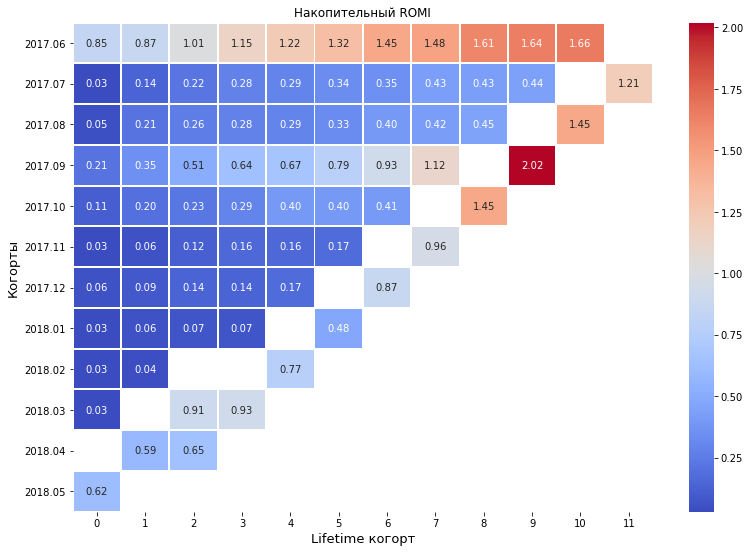

age
0     0.186364
1     0.261000
2     0.412000
3     0.437778
4     0.496250
5     0.547143
6     0.735000
7     0.882000
8     0.985000
9     1.366667
10    1.555000
11    1.210000
dtype: float64

--------------- Расчет окупаемости для рекламного источника № 10 ---------------
None
____Средняя ценность покупателя____
age
0     0.9460
1     2.4200
2     2.4840
3     2.7340
4     3.2640
5     3.5420
6     3.5525
7     3.7875
8     3.8875
9     4.4500
10    4.2050
11    5.6500
dtype: float64


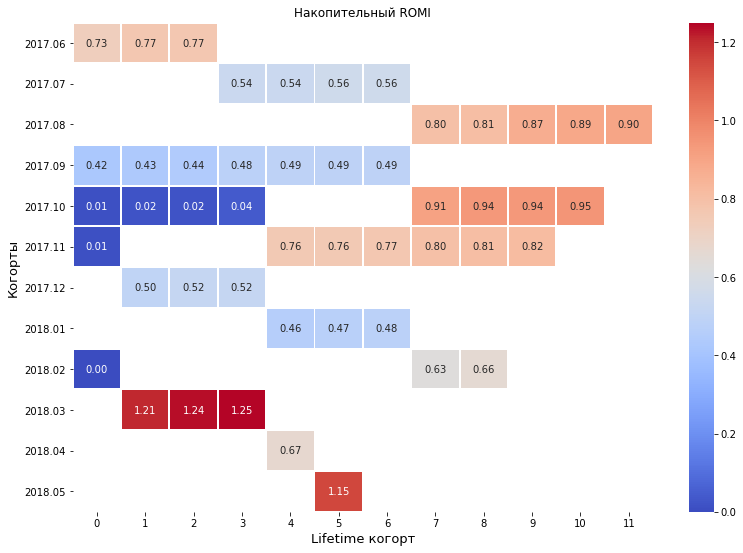

age
0     0.234000
1     0.586000
2     0.598000
3     0.566000
4     0.584000
5     0.686000
6     0.575000
7     0.785000
8     0.805000
9     0.876667
10    0.920000
11    0.900000
dtype: float64



In [101]:
# Подготовим список источников, по которым хотим построить метрики
source_list = [1, 2, 3, 4, 5, 9, 10]

# Сделаем цикл, который по очереди построит метрики для разлиных рекламных источников:
for s in source_list:
    print(print('-'*15, 'Расчет окупаемости для рекламного источника №', s, '-'*15))
    # Посчитаем количество новых покупателей за каждый месяц и построим когорты, объединим таблицы:
    cohort_sizes_new = (orders[orders['source_id'] == s]
                        .groupby('first_order_month')
                        .agg({'uid': 'nunique'}).reset_index())
    cohort_sizes_new.columns = ['first_order_month', 'n_buyers']
    
    cohorts_new = (orders[orders['source_id'] == s]
                   .groupby(['first_order_month','purchase_month'])
                   .agg({'revenue': 'sum'}).reset_index())
    report_3 = pd.merge(cohort_sizes_new, cohorts_new, on='first_order_month')
    # Рассчитаем возраст когорт и найдем LTV:
    report_3['age'] = ((report['purchase_month'] - report['first_order_month']) / \
                       np.timedelta64(1, 'M')).round().astype('int')
    report_3['ltv'] = report_3['revenue'] / report_3['n_buyers']
    # Добавим в таблицу данные о затратах:
    monthly_costs_by_source = costs[costs['source_id'] == s].groupby('month')['costs'].sum()
    report_3 = pd.merge(report_3, monthly_costs_by_source, left_on='first_order_month', right_on='month')
    # РАссчитаем стоимость привлечения одного покупателя и окупаемость:
    report_3['cac'] = report_3['costs'] / report_3['n_buyers']
    report_3['romi'] = report_3['ltv'] / report_3['cac']
    report_3['cohort_month'] = report_3['first_order_month'].dt.strftime('%Y.%m')
    ltv_by_source = report_3.pivot_table(
        index='cohort_month', 
        columns='age', 
        values='ltv', 
        aggfunc='mean').cumsum(axis=1).round(2)
    print("____Средняя ценность покупателя____")
    print(ltv_by_source.mean(axis=0))
    
    # Итоговый отчет ROMI
    romi_by_source = report_3.pivot_table(
        index='cohort_month', 
        columns='age', 
        values='romi', 
        aggfunc='mean').cumsum(axis=1).round(2)
    
    # Постоение тепловой карты ROMI:
    plt.figure(figsize=(13, 9))
    plt.title('Накопительный ROMI')
    sns.heatmap(romi_by_source, annot=True, fmt='.2f', linewidths=1, linecolor='white', cmap = 'coolwarm')
    plt.ylabel("Когорты", fontsize = 13)
    plt.xlabel("Lifetime когорт", fontsize = 13)
    plt.show()
    print(romi_by_source.mean(axis=0))
    print()

ТОП-3 рекламных источника по скорости окупаемости:

1. № 1 (в среднем затраты окупилиь уже на второй месяц)
2. № 5 (когорта окупилась на 4-й месяц)
3. № 2 (когорта окупилась на 5-й месяц)

За все весь рассматриаемый период не окупились источники № 3 и № 10.

По росту LTV лучше всего себя проявили покупатели, которые были привлечены из рекламных источников № 1, 2, 4 и 5.

---
Теперь рассчитаем метрики в зависимости от устроств, используемых при посещении сайта.

--------------- Расчет LTV (пожизненной ценности покупателя) для устройства desktop ---------------
None


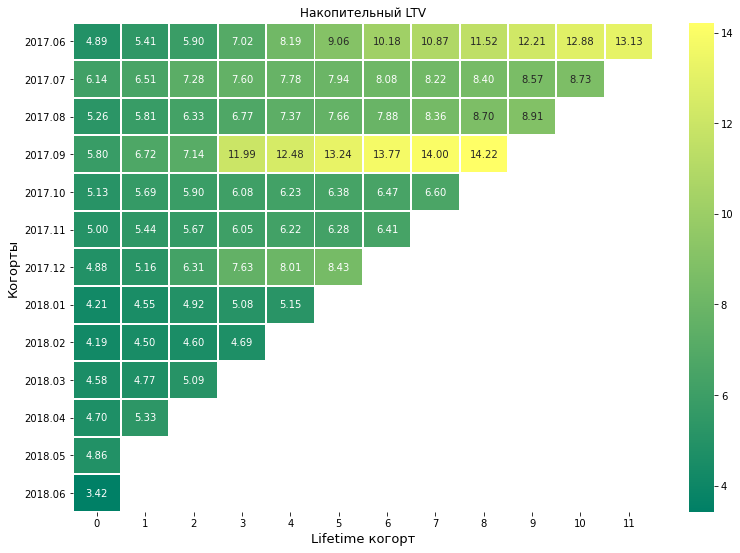

age
0      4.850769
1      5.444545
2      5.914000
3      6.990000
4      7.678750
5      8.427143
6      8.798333
7      9.610000
8     10.710000
9      9.896667
10    10.805000
11    13.130000
dtype: float64

--------------- Расчет LTV (пожизненной ценности покупателя) для устройства touch ---------------
None


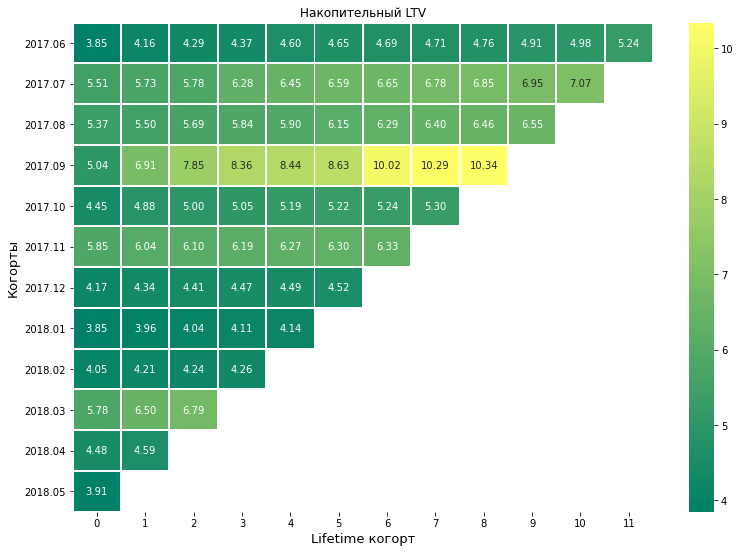

age
0     4.692500
1     5.165455
2     5.419000
3     5.436667
4     5.685000
5     6.008571
6     6.536667
7     6.696000
8     7.102500
9     6.136667
10    6.025000
11    5.240000
dtype: float64



In [102]:
# Подготовим список устройств, по которым хотим построить метрики
device_list = ['desktop', 'touch']

# Сделаем цикл, который по очереди построит метрики для разлиных рекламных источников:
for s in device_list:
    print(print('-'*15, 'Расчет LTV (пожизненной ценности покупателя) для устройства', s, '-'*15))
    # Посчитаем количество новых покупателей за каждый месяц и построим когорты, объединим таблицы:
    cohort_sizes_new = (orders[orders['device'] == s]
                        .groupby('first_order_month')
                        .agg({'uid': 'nunique'}).reset_index())
    cohort_sizes_new.columns = ['first_order_month', 'n_buyers']
    
    cohorts_new = (orders[orders['device'] == s]
                   .groupby(['first_order_month','purchase_month'])
                   .agg({'revenue': 'sum'}).reset_index())
    report_3 = pd.merge(cohort_sizes_new, cohorts_new, on='first_order_month')
    # Рассчитаем возраст когорт и найдем LTV:
    report_3['age'] = ((report['purchase_month'] - report['first_order_month']) / \
                       np.timedelta64(1, 'M')).round().astype('int')
    report_3['ltv'] = report_3['revenue'] / report_3['n_buyers']
    report_3['cohort_month'] = report_3['first_order_month'].dt.strftime('%Y.%m')
 
    # Итоговый отчет LTV:
    ltv_by_device = report_3.pivot_table(
        index='cohort_month', 
        columns='age', 
        values='ltv', 
        aggfunc='mean').cumsum(axis=1).round(2)
    
    # Постоение тепловой карты LTV:
    plt.figure(figsize=(13, 9))
    plt.title('Накопительный LTV')
    sns.heatmap(ltv_by_device, annot=True, fmt='.2f', linewidths=1, linecolor='white', cmap = 'summer')
    plt.ylabel("Когорты", fontsize = 13)
    plt.xlabel("Lifetime когорт", fontsize = 13)
    plt.show()
    print(ltv_by_device.mean(axis=0))
    print()

___
Покупатели, которые делают заказы с компьютера, в среднем приносят больше денег. Возможно это связано с тем, что процесс покупки с мобильного устройства менее удобен.

### Шаг 3. Общий вывод по проекту


<a id = "Step3"></a>

[1](#Step1) [2](#Step2)   [2.1](#Step2.1)   [2.2](#Step2.2)   [2.3](#Step2.3)   [Начало](#Head)

В рамках проекта надо было изучить данные Яндекс.Афиши с июня 2017 по конец мая 2018 года и узнать как люди пользуются продуктом, когда они начинают покупать, сколько денег приносит каждый клиент и когда клиент окупается. Исследование проводилоь с целью оптимизации маркетинговых затрат.

Предварительно данные прошли предобработку, были рассчитаны дополнительные параметры. 

Общая конверсия посетителей сайта в покупателей составила 16%.

Количество уникадьных пользователей сайта:

|Период|  чел. |
|--------:|   --------:     |         
|в день 	  |   907       | 
|в неделю 	  |   5825        |
|в месяц 	  |   23228        |

Cредняя продолжительность сессий составила 60 секунд, регулярность использования сайта по отношению к недельной аудитории - 15.59%. Регулярность использования сайта по отношению к месячной аудитории 3.91%.

Когортый анализ коэффициента удержания и коэффициента оттока показал, что большинство посетителей сайта (более 90%) перестают пользоваться Яндекс.Афишей после первого месяца.

В ходе работы мы выясили, что в половина новых клиентов совершает покупку в течение 16 минут после начала сессии. Среди покупателей сайта только 17 % сделали более 1 покупки за весь рассматриваемы период.

Рассмотрев как изменяется количетсво покупок за весь период, мы пришли к выводу, что данный показатель подчинается сезонности. Пик покупок пришелся на декабрь. Период с октября по март можно считать наиболее активным. Ближе к лету спрос на билеты снижается.

Проведя когортный анализ по количеству покупателей мы установили, что после первого месяца их число сильно сокращается. В каждом новом месяце основную выручку делают новые клиенты.

Средее значение значение выркучки с одного заказа за весь рассматриваемый период составило около 5 у.е. Построив график изменения среднего чека, мы увидели, что несмотря на рост числа покупателей в октябре 2017, выручка снизилась. Это может означать, в этом месяце произошло снижение цен на билеты. Самое сильное падение размера среднего чека произошло в январе 2018 г. Затем к марту цены вновь выросли и размер покупок на одного клиента вернулся к показателям сентября 2017 года.

С помощью когортного анализа было установлено, что размер среднего чека возрастает со второго месяца использования сайта. 
Самая высокая ценность у поупателей из когорты сентября 2017 года - они в среднем принесли по 13.44 у.е. Такое значение получилось за счет крупных покупок, сделанных этой когортой в декабре 2017 г.

За весь рассматриваемый период на маркетинг было потрачено 329131.62 у.е. Около половины всего рекламного бюджета ушло на источник №3. Также в ТОП 3 по затратам вошла реклама из 4 и 5 источников.

График ежемесячного затрат на рекламу подтвердил наличие сезонности. С сентября по декабрь затраты на рекламу постоянно растут. Пик затрат приходится на декабрь, что говорит об активном привлечении покупатей в предпраздничный период. Далее к лету рекламный бюджет сокращается.

Сравнивая среднюю стоимость привлечения одного покупателя по различным рекламным источникам с выручкой, которую он приносит,
было выявлено, что реклама по каналам № 3-й, 4-й и 10-й является убыточной. Средняя стоимость привлечения одного покупателя через источник №3 в 2.5 раза превышает получаемую выручку. Самым успешным каналом привлечения можно считать № 1 - средняя выручка с одного покупателя превышает средние расходы на 3.55 у.е.
Расчет показателя окупаемости маркетинговых вложений показал, что в среднем новые клиенты окупаются после 9 месяцев.

ТОП-3 рекламных источника по скорости окупаемости:

    № 1 (в среднем затраты окупилиь уже на второй месяц)
    № 5 (когорта окупилась на 4-й месяц)
    № 2 (когорта окупилась на 5-й месяц)

По росту LTV лучше всего себя проявили покупатели, которые были привлечены из рекламных источников № 1, 2, 4 и 5.
Также было установлено, что покупатели, которые делают заказы с компьютера, в среднем приносят больше денег. Возможно это связано с тем, что процесс покупки с мобильного устройства менее удобен.

**Рекомендации по выбору рекламных платформ**

На основе проведенного анализа рекомендуется в дальнейшем продолжить использование рекламных источников № 1, № 2 и № 5 потому что покупатели, привлекаемые оттуда, приносят больше выручки, а также эти каналы окупаются быстрее остальных. Вполне можно использовать рекламный канал № 9, хотя он окупается подольше и ценность покупателя не такая высокая. 
Следует отказаться от источников № 3 и № 10, так как они не окупилилсь за весь рассматриваемый период. Также рекомедуется поработать над улучшением мобильной версии сайта. Возможно, если внести некоторые доработки, клиенты станут чаще покупать билеты с мобильных телефонов или планшетов. 